In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import math
import scipy.stats as ss
#forkity fork

# Assignment 4 - Classification

For this assignment, you'll need to perform a classification on a dataset, as well as do some prep work on the data. 

The exact steps of what you need to do are flexible and up to you to some degree, however you should consider some of the important things we've mentioned recently, such as:
<ul>
<li> Is the target balanced?
<li> Are there missing or erroneous values?
<li> Are there categorical or numerical features?
<li> Is there colinearity?
<li> Are there outliers?
<li> Should we normalize? 
<li> Do the distributions of the features give any indication that some may need work? 
</ul>

Basically, the data is in the original, potentially dirty, format, and you need to find what should be cleaned, and do the cleaning. There is not one "right" answer to what has to be done, and you'll probably need to do it with at least something of an iterative process - find an issue, correct it, check the data, repeat.

<b>The target that we are predicting is the loan_status. </b>

## Grading

The grades will be broken down as follows:
<ul>
<li> <b>30%</b> - a working predictive model with a reasonable level of accuracy. 
    <ul>
    <li> For the accuracy part, it will not be explicitly graded, but compared to all the others. If you're in the same general range, that's good - if yours is drastically less accurate (or, I guess more accurate), then I'll adjust. There won't be a comparison of "this person is 72.3% and this person is only 71.8% accurate, they fail."
    <li> This data is larger than most of the small sample sets, so random variations due to train-test splits shouldn't be too bad. (If you're a keener you could loop)
    <li> I will use the F1 score as the accuracy metric. 
    </ul>
<li> <b>40%</b> - a clear and readable description of what steps you took to prepare the data, and a brief not on the rationale behind it. Did you do a log transformation to a skewed feature, did you remove outliers, did you remove a feature that has a lot of missing values? Please put this somewhere obvious and readable, consider the goal of the assignment to explain your process to me. 
    <ul>
    <li> E.g. "The target data was imbalanced, so I tried several resampling methods and chose the one with the highest accuracy of the resulting model", "the feature X had the same value for 95% of records, so I dropped it". 
    <li> In this, please also state if you see a group that appears to be a good credit risk, and a group that is a bad credit risk, and indicate the evidence showing that. Please do this other than the most simplistic way - more money = better credit. If there are no such groups, state why you think this. This will likely be about 3 - 5 statements or points, you should provide evidence from the data, but it does not need to be an essay. (You may want to consider this question after you're pretty much done with the data prep and modelling.)
    </ul>
<li> <b>30%</b> - allowing your model to be "deployed". At the bottom of this file there is a small block of code to load in some test data (that I have), and calculate your accuracy. Your contribution to this part is to have a model that is ready to make predictions. Some specifics to consider:
    <ul>
    <li> The test data will be in exactly the same format as the dataset you're given. So any steps that you took to prepare your data for modelling will need to be mirroed here, so the new  data can be predicted. The easiest way to do this is to use a pipeline, but it is up to you. Remember the model only accepts data that is in a certain format - the one that you had the data in when it was trained, so when making predictions you need to make sure that is true. 
    <li> Since I'm providing test data, and your task is to just create a model, think about how that might impact your train-test splitting, both as you're developing and for the final product. 
    <li> Once the model is trained it should predict any data that is in the right format, so I should be able to provide any proper dataset, click run on that testing cell, and get predictions. I will not be doing anything that will purposefully make this harder or trickier, like including data that has errors or is in the wrong format, I just split the entire set of data, reserved part of it to test accuracy, and gave the rest to you. Things that you've changed (e.g. dropping a column, one-hot encoding) do need to be replicated at some point before the model can accept the new data to predict. In general we <b>do</b> want to check in our processing that our input is valid, this is kind of a junior introduction to that. 
    </ul>
</ul

# What I did
 1. `Unnamed: 0` seems like it was a index and doesn't have any real point, removed completely
 1. `cb_person_cred_hist_length` was basically identical between `loan_status` 1 & 0 can be removed for faster machine learning
 1. remove outliers in `person_income` anyone above 200K skewed the numbers
 1. remove outliers in `loan_percent_income` keep anything below .65
 1. remove that anyone that has `person_emp_length` above 50
 1. drop rows that have nulls in `loan_int_rate`
 1. drop the octagenarians and greater in `person_age` they are outliers in our data
 1. drop any potential people with a `person_age` under 18 that would probably be a mistake
 1. do a 1hot for the catergorical features
 1. taget was imbalanced, under-sampled using `TomekLinks`

# Good Credit Risk
1. people who own their home (outright I assume) are a good credit risk 
1. they make up 7% of the sample overall but make up 9% of the people with a loan_status of 0

# Bad credit Risk
1. People getting aloan for debt consolidation 
1. make up 15% of the sample overall but make up 20% of the people with a loan_status of 1

## Load Credit Data

In [109]:
def PrepareData(dataFrame:pd.DataFrame):
    if type(dataFrame) != pd.DataFrame:
        raise RuntimeError("that is not a data frame")
    #drop columns
    dataFrame.drop(columns = {"Unnamed: 0", "cb_person_cred_hist_length"}, inplace = True)
    dataFrame = dataFrame[dataFrame["person_income"] < 300000]
    dataFrame = dataFrame[dataFrame["loan_percent_income"] < 0.65]
    dataFrame = dataFrame[dataFrame["person_emp_length"] < 50]
    dataFrame = dataFrame[~dataFrame["loan_int_rate"].isnull()]
    dataFrame = dataFrame[dataFrame["person_age"] > 18]
    dataFrame = dataFrame[dataFrame["person_age"] < 80]
    dataFrame["person_income"] = np.log(dataFrame["person_income"])
    dataFrame = dataFrame[dataFrame["person_home_ownership"] != "OTHER"]
    dataFrame = pd.get_dummies(dataFrame, drop_first=True)
    return pd.DataFrame(dataFrame)

In [110]:
df = pd.read_csv("train.csv")
df = PrepareData(df)

In [33]:
df.head()
df["loan_status"].value_counts()

0    17802
1     4895
Name: loan_status, dtype: int64

         person_age  person_income  person_emp_length     loan_amnt  \
count  22697.000000   22697.000000       22697.000000  22697.000000   
mean      27.679781      10.928318           4.781645   9620.029079   
std        6.117593       0.535787           4.021673   6275.445768   
min       20.000000       8.313852           0.000000    500.000000   
25%       23.000000      10.584461           2.000000   5000.000000   
50%       26.000000      10.917848           4.000000   8000.000000   
75%       30.000000      11.284995           7.000000  12300.000000   
max       76.000000      12.591335          38.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  
count   22697.000000  22697.000000         22697.000000  
mean       11.029320      0.215667             0.169757  
std         3.235897      0.411294             0.104948  
min         5.420000      0.000000             0.010000  
25%         7.900000      0.000000             0.090000  
50%        1

<AxesSubplot:xlabel='person_income', ylabel='Density'>

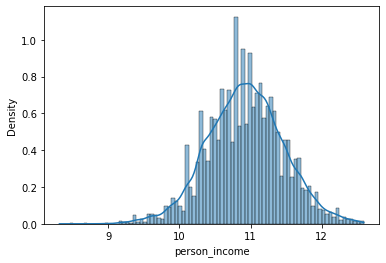

In [80]:
print(df.describe())
sns.histplot(df["person_income"], kde=True, stat="density")
# print("greater than 80:",len(df[df["person_age"] >80]))

In [93]:
df.dtypes


person_age                     int64
person_income                float64
person_home_ownership         object
person_emp_length            float64
loan_intent                   object
loan_grade                    object
loan_amnt                      int64
loan_int_rate                float64
loan_status                    int64
loan_percent_income          float64
cb_person_default_on_file     object
dtype: object

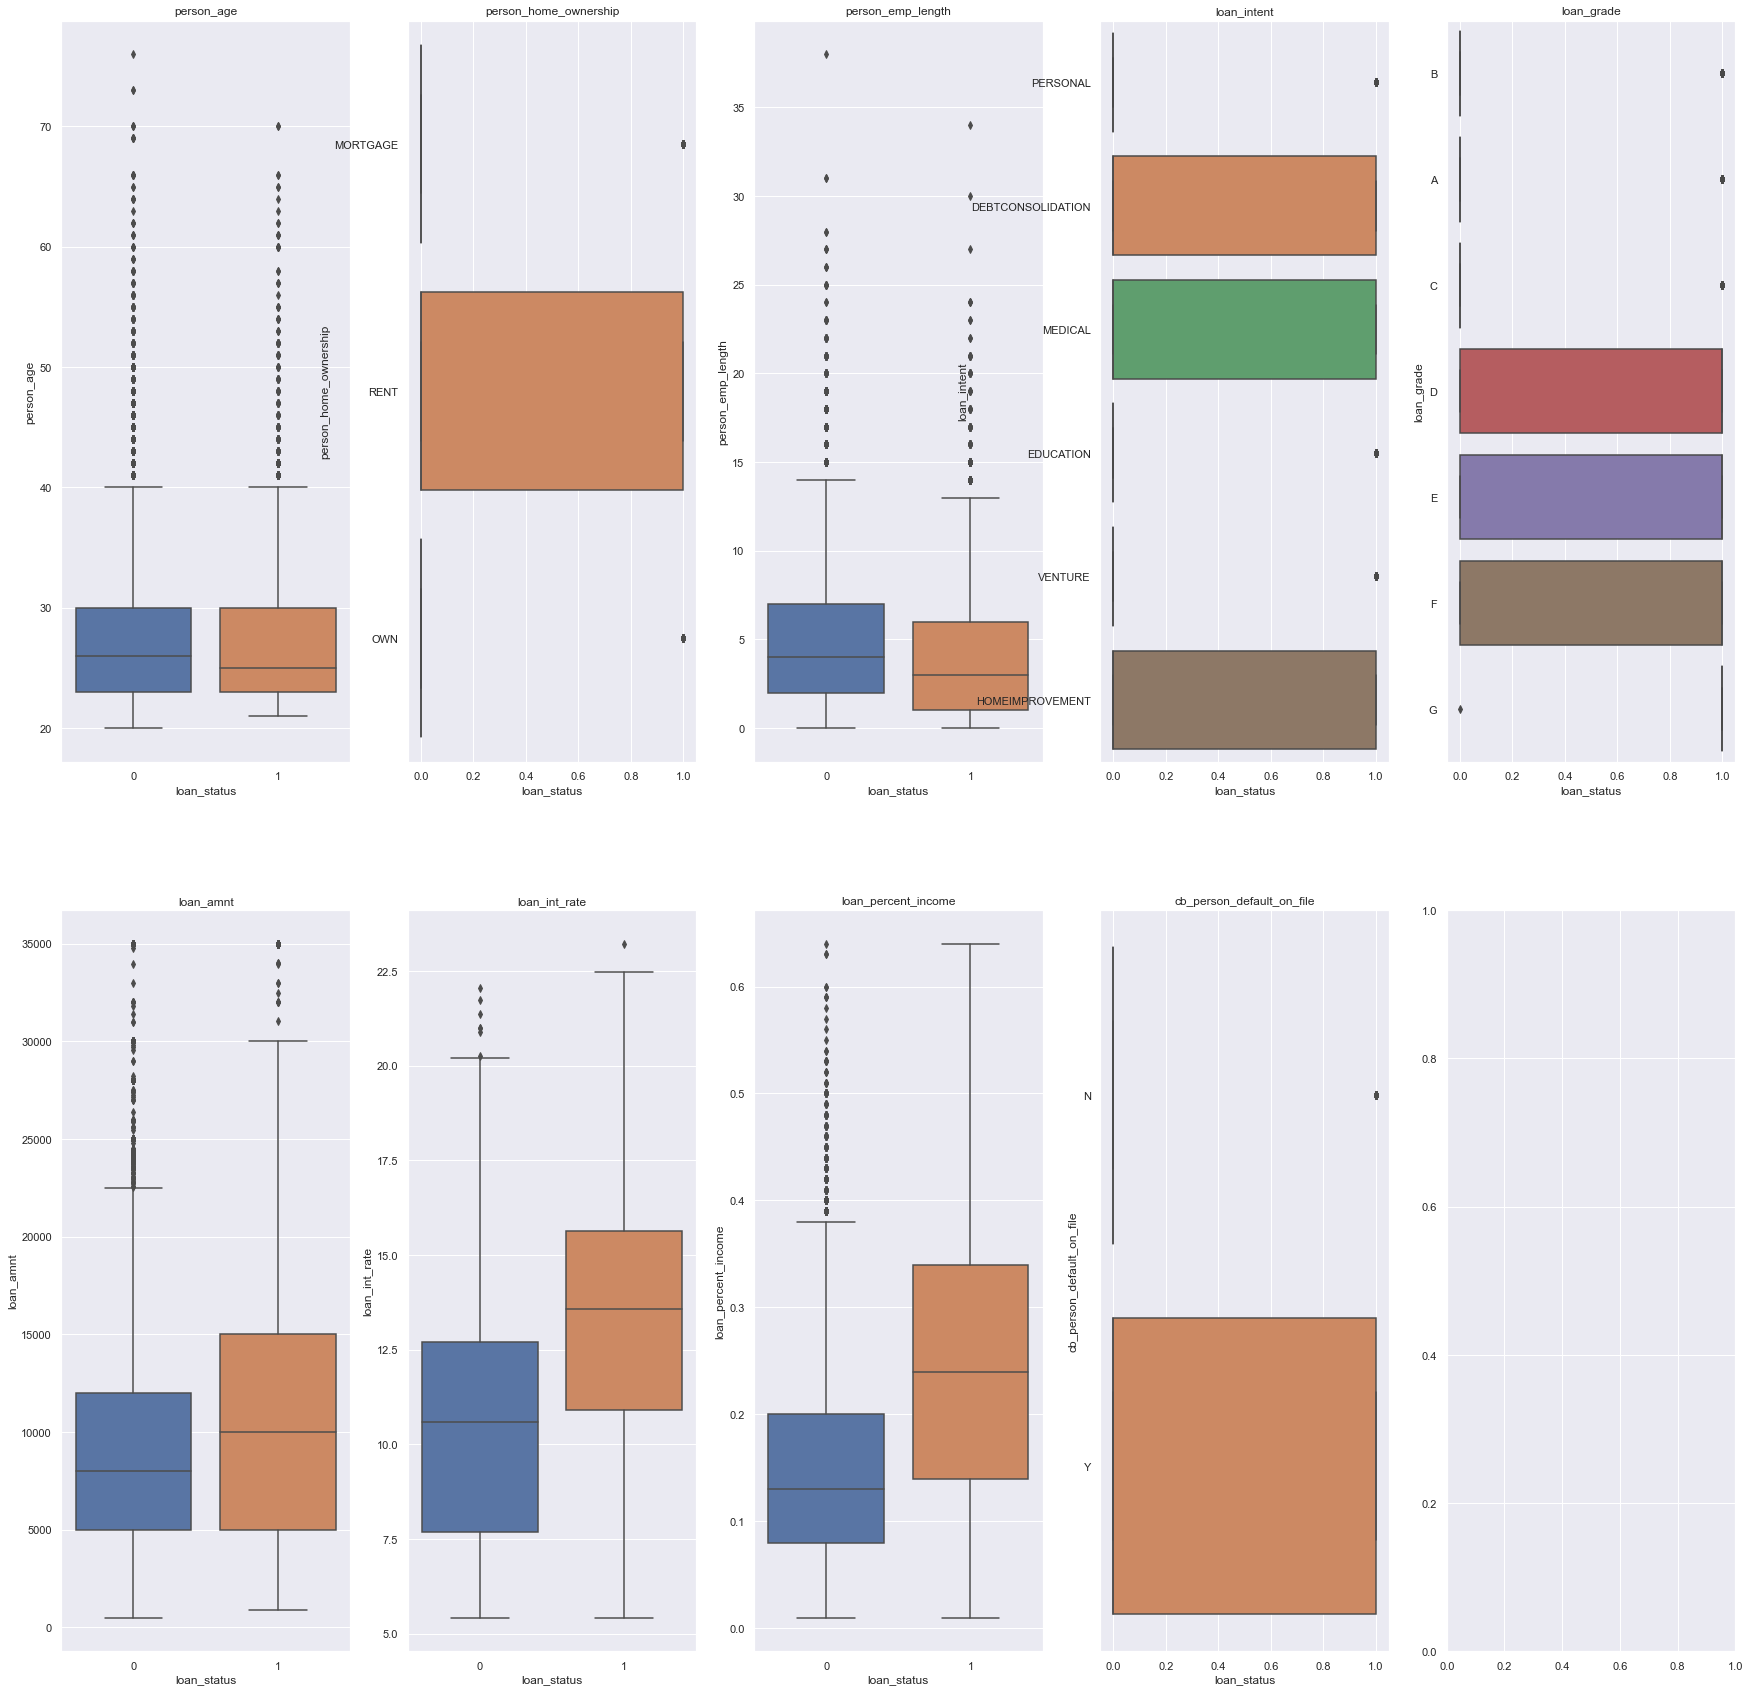

In [92]:
#Visualize differences
feats = df.drop(columns={"loan_status"}).columns
gCols = 5
#gRows = math.ceil( (len(feats) - 1) /gCols )
gRows = math.ceil( len(feats) /gCols )

f, axes = plt.subplots(ncols=gCols, nrows=gRows, figsize=(30,30))
i = 0
q = 0
for column in feats:
    if column != "person_income":
        #sns.kdeplot(data=df, x=str(column), hue="Class", ax=axes[q][i])
        sns.boxplot(x="loan_status", y=str(column), data=df, ax=axes[q][i])
        axes[q][i].set_title(str(column))
        i += 1
        if i >= gCols:
            i = 0
            q += 1

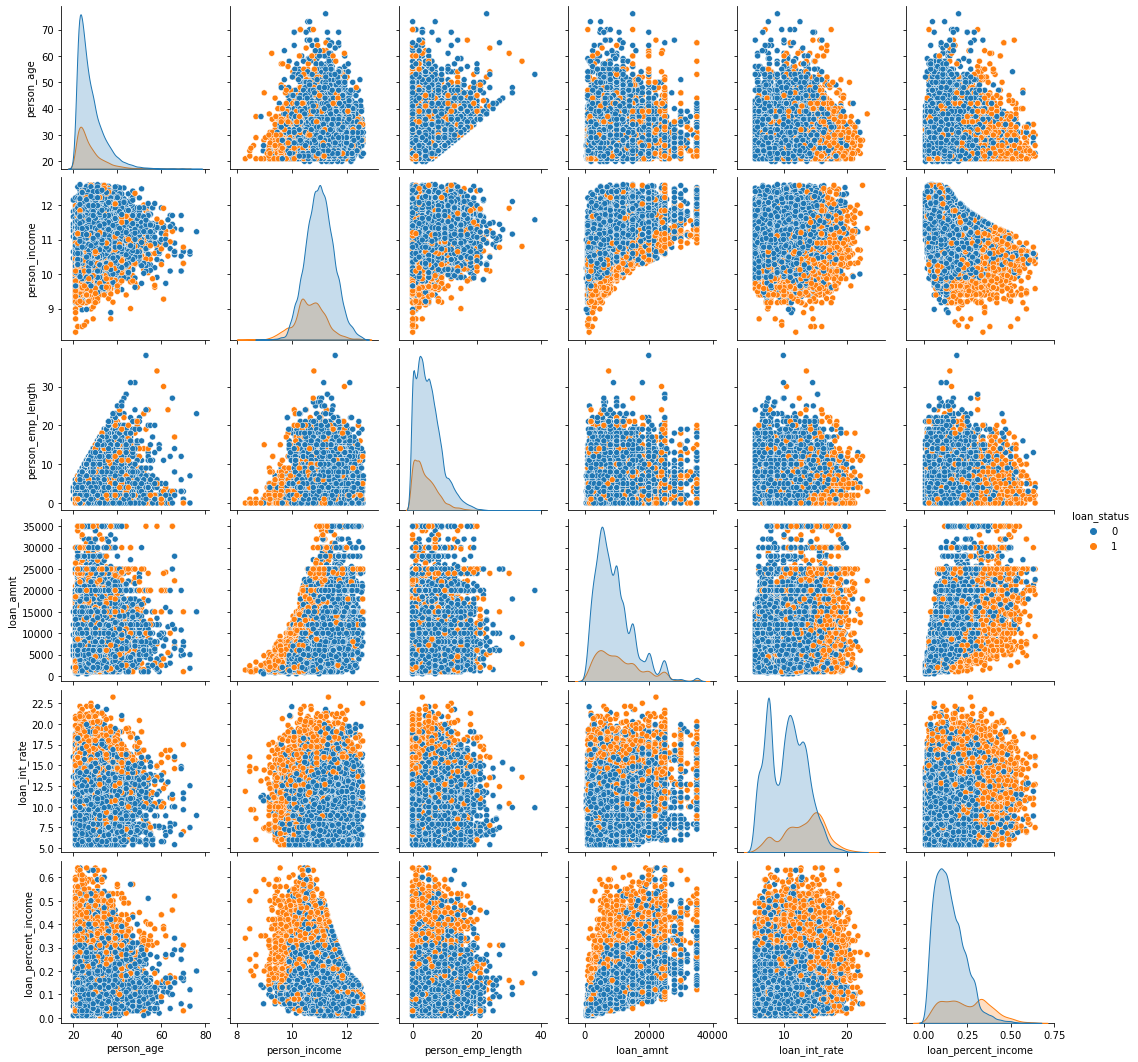

In [48]:
sns.pairplot(df, hue="loan_status")

In [46]:
df.dtypes

person_age                     int64
person_income                float64
person_home_ownership         object
person_emp_length            float64
loan_intent                   object
loan_grade                    object
loan_amnt                      int64
loan_int_rate                float64
loan_status                    int64
loan_percent_income          float64
cb_person_default_on_file     object
dtype: object

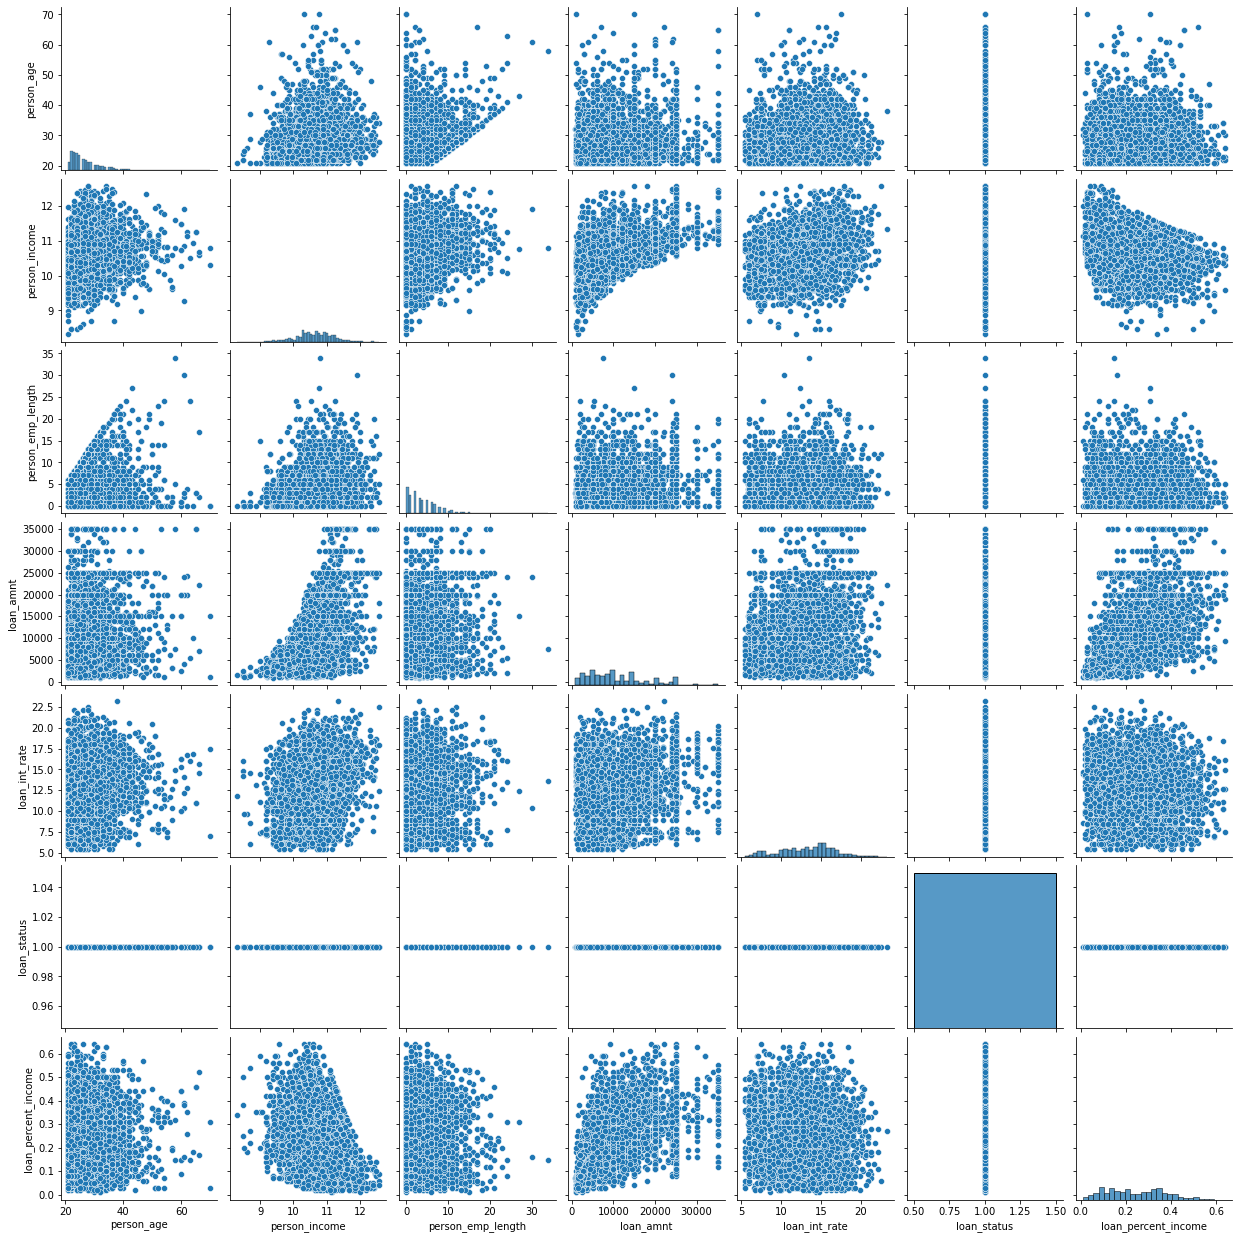

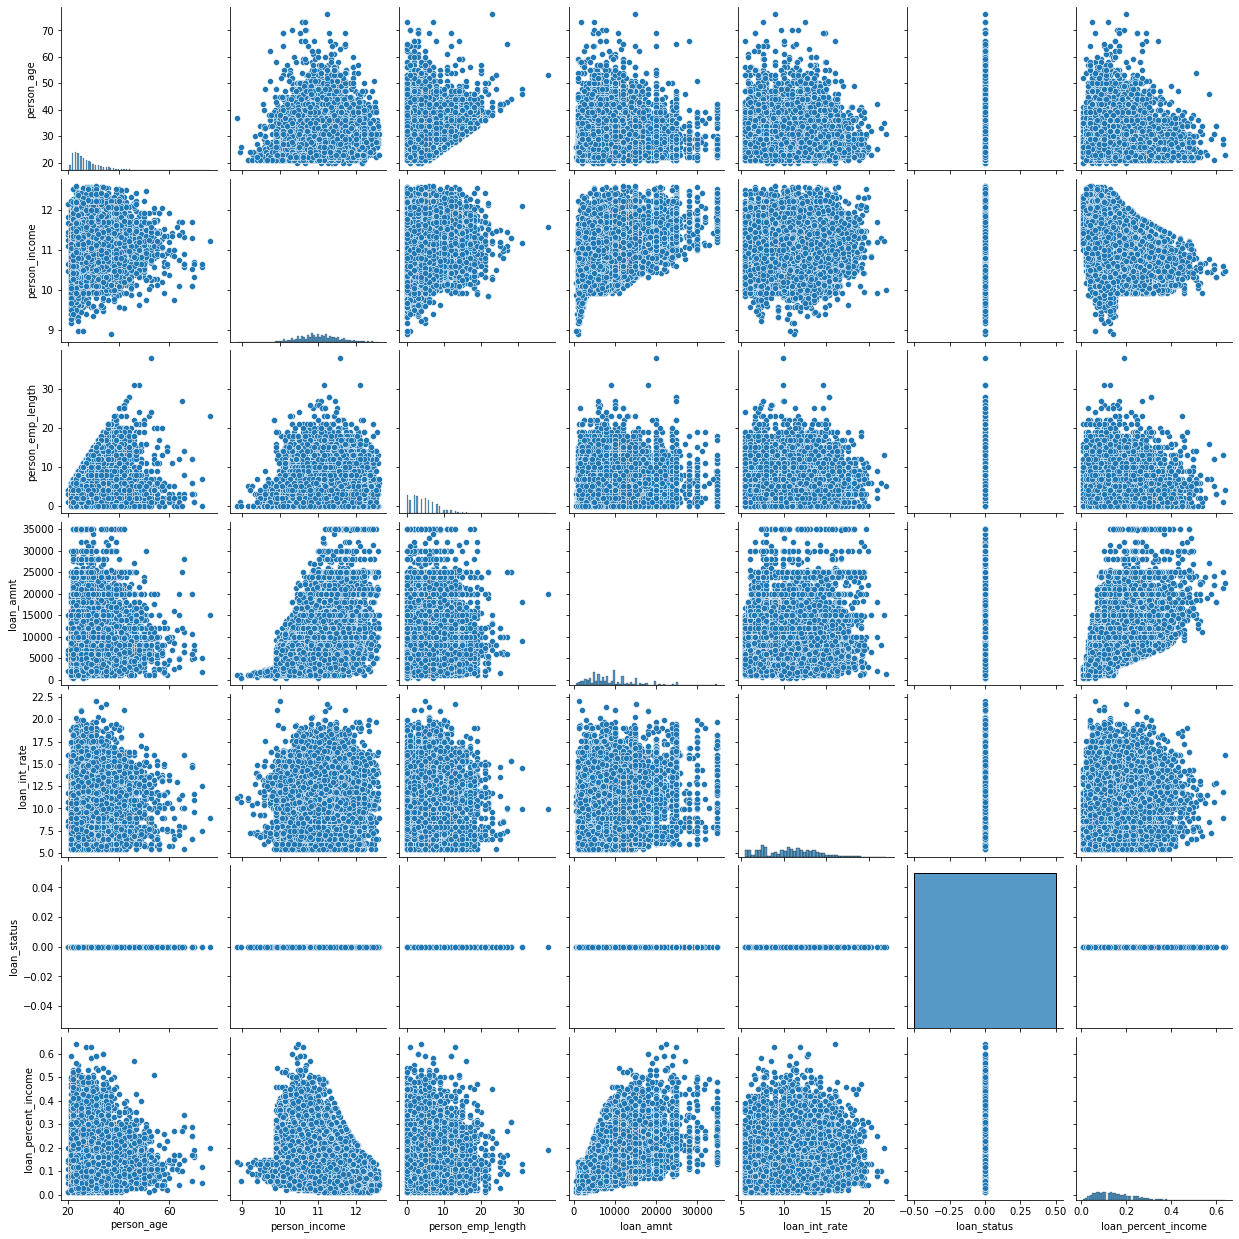

In [53]:
dfBadStatus = df[df["loan_status"] == 1]
dfGoodStatus = df[df["loan_status"] == 0]

sns.pairplot(dfBadStatus)
sns.pairplot(dfGoodStatus)

# tTestBad = dfBadStatus.drop(columns={"person_income","person_home_ownership","loan_intent","loan_grade","cb_person_default_on_file"})
# tTestGood = dfGoodStatus.drop(columns={"person_income","person_home_ownership","loan_intent","loan_grade","cb_person_default_on_file"})

# for column in tTestBad.columns:
#     print(column, ss.mannwhitneyu(dfBadStatus[column], dfGoodStatus[column]))

# sns.scatterplot(y=dfBadStatus["person_age"], x=dfBadStatus["person_income"])
# plt.axvline(df["person_income"].mean())
# plt.show()
# sns.scatterplot(y=dfGoodStatus["person_age"], x=dfGoodStatus["person_income"])
# plt.axvline(df["person_income"].mean())
# plt.show()

<AxesSubplot:xlabel='person_home_ownership', ylabel='count'>

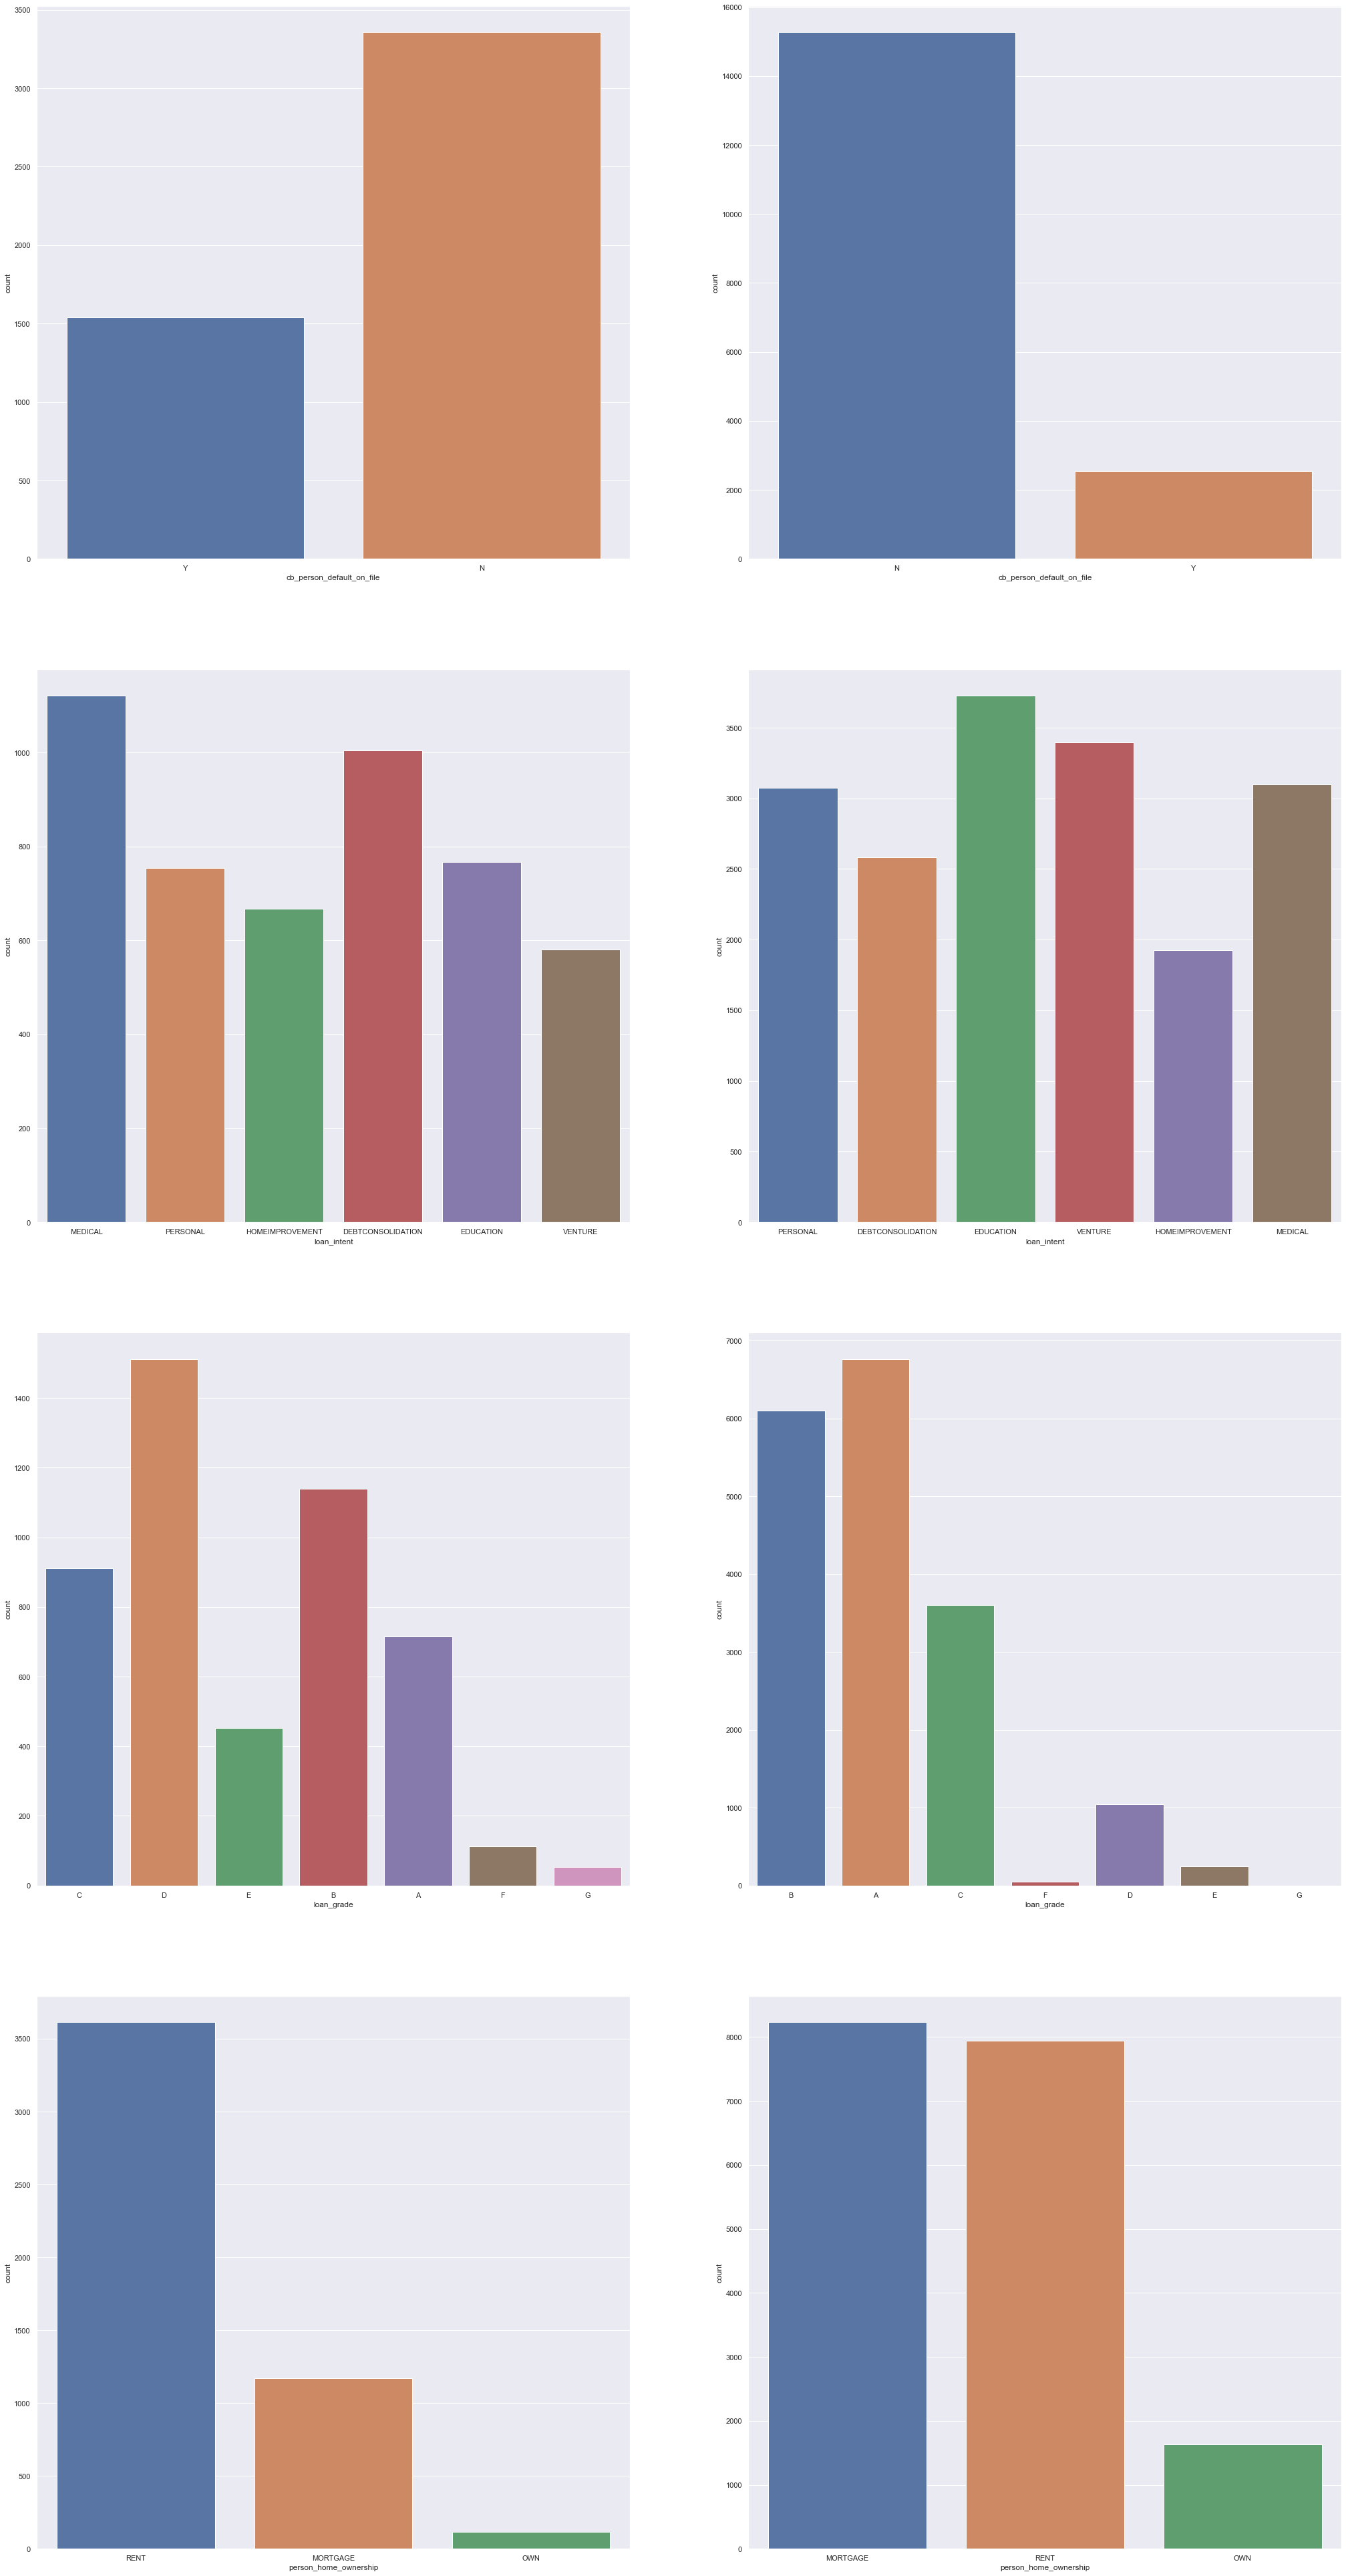

In [97]:
f, axes = plt.subplots(4,2)
plt.rcParams["figure.figsize"] = (35,70)
sns.countplot(x=dfBadStatus["cb_person_default_on_file"], ax = axes[0,0])
sns.countplot(x=dfGoodStatus["cb_person_default_on_file"], ax = axes[0,1])

sns.countplot(x=dfBadStatus["loan_intent"], ax = axes[1,0])
sns.countplot(x=dfGoodStatus["loan_intent"], ax = axes[1,1])

sns.countplot(x=dfBadStatus["loan_grade"], ax = axes[2,0])
sns.countplot(x=dfGoodStatus["loan_grade"], ax = axes[2,1])

sns.countplot(x=dfBadStatus["person_home_ownership"], ax = axes[3,0])
sns.countplot(x=dfGoodStatus["person_home_ownership"], ax = axes[3,1])


In [108]:
print(len(df[df["loan_intent"] == "DEBTCONSOLIDATION"])/len(df))
print(len(dfBadStatus[dfBadStatus["loan_intent"] == "DEBTCONSOLIDATION"])/len(dfBadStatus))

0.15808256597788253
0.20531154239019409


F1: 0.8200956937799043
Acc: 0.9337444933920704
Recall: 0.726271186440678
Precision: 0.9417582417582417


<AxesSubplot:>

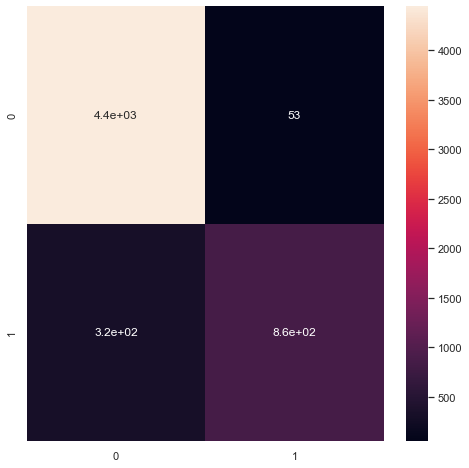

In [113]:
##Train Test split version for testing accuracy

# # sampler = ADASYN(n_jobs=-1) #F1:.728, .890, .700, .759 (standard scale)
# # sampler = RandomUnderSampler() #F1:.691, .846, .794, .612 (standard scale)
# # sampler = RandomOverSampler() #F1:.701, .853, .793, .628 (standard scale)
# sampler = TomekLinks(n_jobs=-1) #F1:.832, .934, .744, .944 (standard scale)
# # sampler = SMOTE(n_jobs=-1) #F1:.729, .884, .713, .746 (standard scale)
# # sampler = SVMSMOTE(n_jobs=-1) #F1:.728, .877, .751, .706 (standard scale)

# scaler = StandardScaler()

# ye = np.array(df["loan_status"]).reshape(-1,1)
# xe = df.drop(columns={"loan_status"})


# X_train, X_test, y_train, y_test = train_test_split(xe, ye)
# X_trainSamp, y_trainSamp = sampler.fit_resample(X_train, y_train)

# X_train_norm = scaler.fit_transform(X_trainSamp)
# X_test_norm = scaler.transform(X_test)

# poly = PolynomialFeatures(degree=3)
# model = make_pipeline(poly, RandomForestClassifier(n_jobs=-1))
# model.fit(X_train_norm, y_trainSamp)
# preds = model.predict(X_test_norm)
# labels = binarize(np.array(preds).reshape(-1,1), threshold=.5)

# print("F1:",f1_score(y_test, labels))
# print("Acc:",accuracy_score(y_test, labels))
# print("Recall:",recall_score(y_test, labels))
# print("Precision:",precision_score(y_test, labels))
# plt.rcParams["figure.figsize"] = (8,8)
# sns.heatmap(confusion_matrix(y_test, labels), annot=True)

In [114]:
# sampler = ADASYN(n_jobs=-1) #F1:.728, .890, .700, .759 (standard scale)
# sampler = RandomUnderSampler() #F1:.691, .846, .794, .612 (standard scale)
# sampler = RandomOverSampler() #F1:.701, .853, .793, .628 (standard scale)
sampler = TomekLinks(n_jobs=-1) #F1:.832, .934, .744, .944 (standard scale)
# sampler = SMOTE(n_jobs=-1) #F1:.729, .884, .713, .746 (standard scale)
# sampler = SVMSMOTE(n_jobs=-1) #F1:.728, .877, .751, .706 (standard scale)

scaler = StandardScaler()

ye = np.array(df["loan_status"]).reshape(-1,1)
xe = df.drop(columns={"loan_status"})


X_trainSamp, y_trainSamp = sampler.fit_resample(xe, ye)

poly = PolynomialFeatures(degree=3)
model = make_pipeline(StandardScaler(), poly, RandomForestClassifier(n_jobs=-1))
model.fit(X_trainSamp, y_trainSamp)
preds = model.predict(X_trainSamp)
labels = binarize(np.array(preds).reshape(-1,1), threshold=.5)

# print("F1:",f1_score(y_test, labels))
# print("Acc:",accuracy_score(y_test, labels))
# print("Recall:",recall_score(y_test, labels))
# print("Precision:",precision_score(y_test, labels))
# plt.rcParams["figure.figsize"] = (8,8)
# sns.heatmap(confusion_matrix(y_test, labels), annot=True)

### Accuracy Test

Replace the green part with whatever you need to transform the fresh data into the format needed for your model to predict. 

<b>Note:</b> you could test and make sure that things are working OK here by taking part of your dataset, saving it in a separate CSV, and running it through here as a piece of test data. The accuracy results would be useless, but you'd confirm that the model works properly. 

In [3]:
d_test = pd.read_csv("test.csv")
d_test = PrepareData(d_test)

ye = np.array(d_test["loan_status"]).reshape(-1,1)
xe = d_test.drop(columns={"loan_status"})

xtest, ytest = sampler.fit_resample(xe, ye)

finalPred = model.predict(xtest)
prediction_labels = binarize(np.array(finalPred).reshape(-1,1), threshold=.5)
######################
# Insert whatever you need to do to prep the data here. 
# It might be nothing if you have a big pipeline. 
# Ensure that at the end your data is in two arrays - xtest and ytest
# Ensure the name of your final model is "model"
# Each should contain the ENTIRE x or y dataset in the test data. 
#
# This part should be reusable - any dataset in this format should just run
# and generate predictions and accuracy stats. 
# Please DO NOT do any train-test splitting here. 
#######################

# This should work once you're done, as is. 
# uncomment the stuff below when ready to run.
print("F1:",f1_score(ytest, prediction_labels))
conf_matrix = confusion_matrix(ytest, prediction_labels)
sns.heatmap(conf_matrix, annot=True)